# Classification: Bank Marketing

## Setup

It is another wonderful day at MLSolutions Inc. and you have been assigned a new task. A new client, Portuguese Bank, has been calling potential customers and asking them questions and recorded if they have eventually subscribed to a product (bank term deposit). Your job as a data scientist is to create a model that predicts if a person will subscribe or not. 

## Importing Libraries

In [1]:
!pip install imblearn

In [2]:
SEED = 123
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from imblearn.under_sampling import RandomUnderSampler

## Loading Dataset

In [3]:
dataset = pd.read_csv('datasets/bank_marketing.csv', sep=';')
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Exploratory Data Analysis

Firstly, we need to understand what each column means. 

age, job, marital, education are self-explanatory;

default - has this person ever failed to pay back the debt in time;

balance - average yearly balance;

housing - does this person have a mortgage;

loan - does this person has a personal loan;

contact - commpunication type;

day - day of the month when this person was contacted last time;

month - month when this person was contacted last time;

duration - duration of the last contact (in seconds);

campaign - number of contacts during this campaign;

pdays - number of days since the contact from previous campaign;

previous - number of contacts performed before this campaign;

poutcome - outcome of the previous marketing campaign.

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


We can see that there are no missing values in the dataset, which is weird for a real data. People who collect data at this bank must be real good! Now lets look at some of the variables in detail.

From info() output above, we can see that 7 columns are integer types and 10 other columns are object type. This means that we can create two lists: one will hold the names of numerical columns (int), and other will hold categorical columns (object).

In [5]:
num_cols = dataset.select_dtypes(include=['int64']).columns.values
cat_cols = dataset.select_dtypes(include=['object']).columns.values
cat_cols = cat_cols[cat_cols != 'y']

### Numerical Columns

Now lets look at numerical columns first.

In [6]:
dataset.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


There are a few interesting things we can see:

1. 50% of all people called were between 33 and 48.

2. 25% of people called have less than 72 euros in their account, with someones having a debt of 8019 euros. 

3. On average, people have been contacted twice throughout the campaign, with someone being contacted 63 times!!!

4. At least 75 % of people haven't been called in the previous campaigns (pdays = -1).

Moreover, pdays does not really provides us with any additional information except if the person was contacted in the past or not. So we can create a new column that records this information and remove pdays.

In [7]:
dataset['contacted_before'] = np.where(dataset['pdays'] == -1, 'no', 'yes')
dataset.drop(['pdays'], axis=1, inplace=True)
num_cols = num_cols[num_cols != 'pdays']
cat_cols = np.append(cat_cols, ['contacted_before'])

### Categorical columns

First lets start with graphing all categorical columns and their counts.

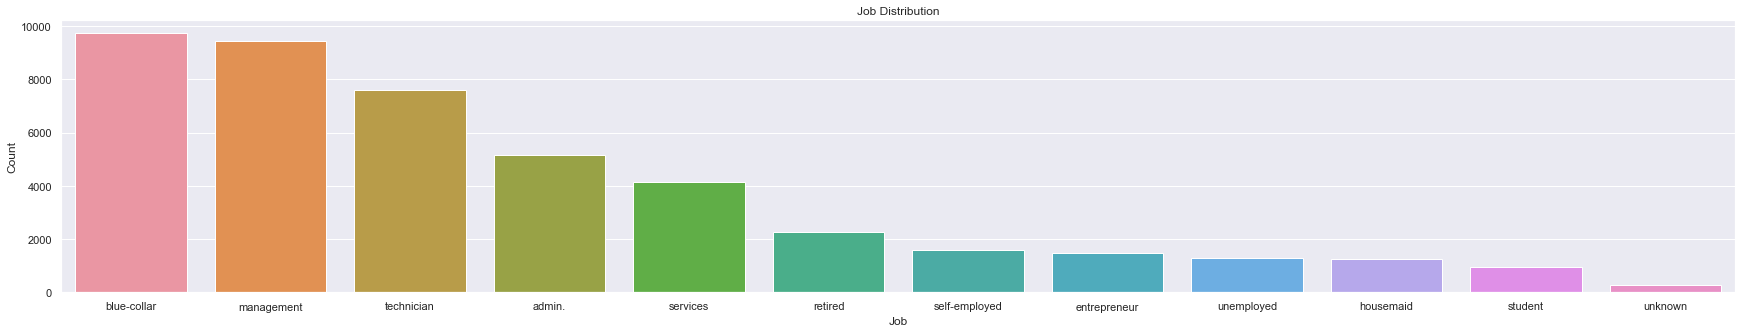

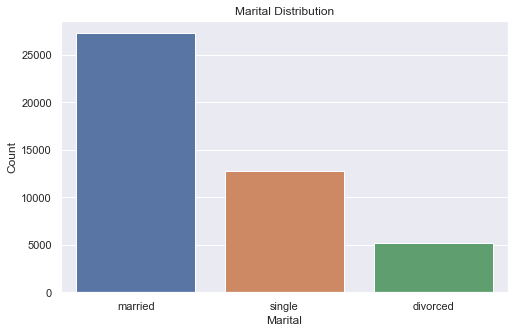

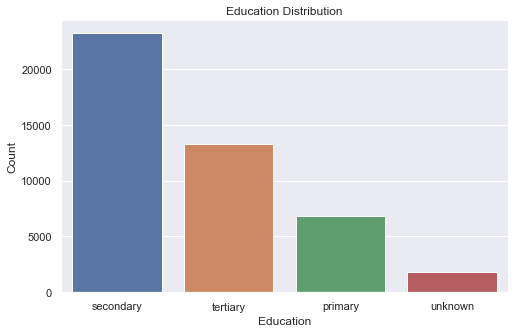

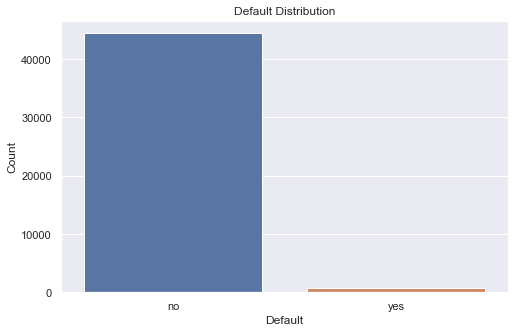

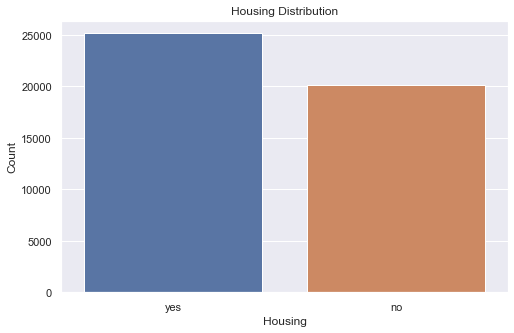

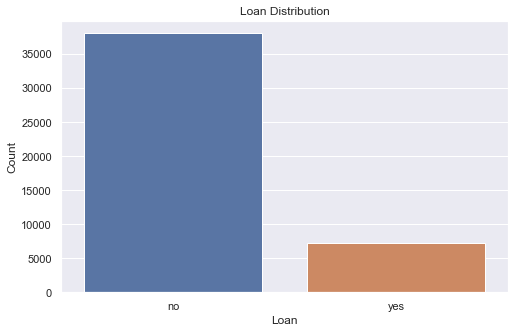

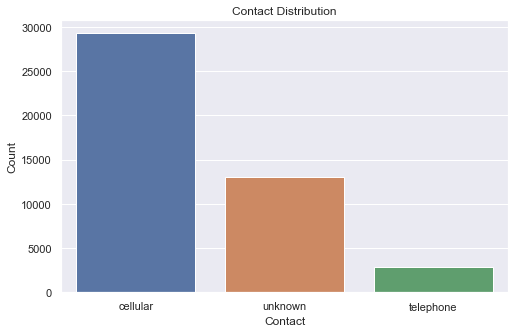

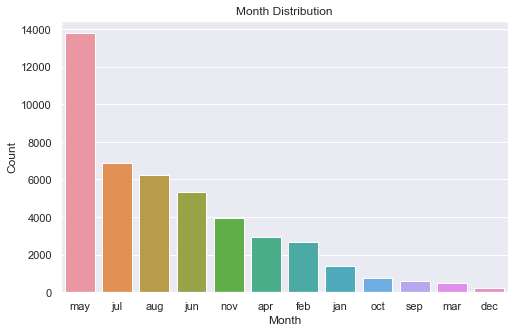

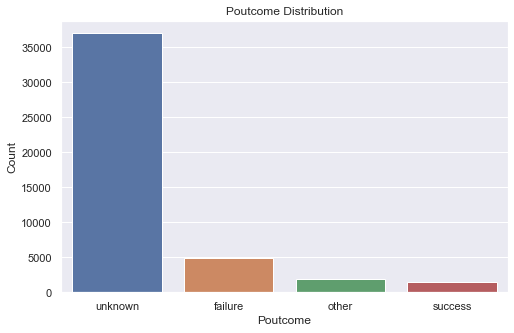

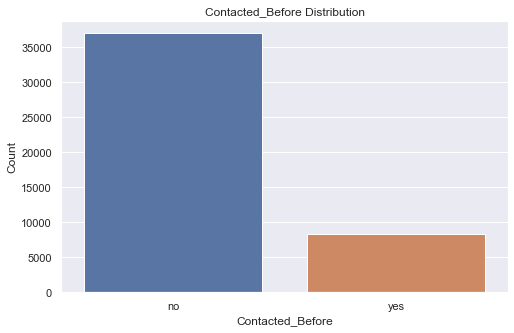

In [8]:
for column in cat_cols:
    if column == 'job':
        sns.set(rc={'figure.figsize': (30, 5)})
    else:
        sns.set(rc={'figure.figsize': (8,5)})
    sns.countplot(x=column, data=dataset, order=dataset[column].value_counts().index)
    plt.xlabel(column.title())
    plt.ylabel('Count')
    plt.title(column.title() + ' Distribution')
    plt.show()

The graphs above do not give any interesting insights into the data; however, they clearly show a few ways in which we can improve our data. 

## Data Preprocessing

### Data Cleanup, Standardisation and Encoding

Firstly, lets replace all the unknown values with columns most common value.

In [9]:
dataset.replace('unknown', np.nan, inplace=True)
for column in cat_cols:
    dataset[column] = dataset[column].fillna(dataset[column].mode()[0])
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,contacted_before
0,58,management,married,tertiary,no,2143,yes,no,cellular,5,may,261,1,0,failure,no,no
1,44,technician,single,secondary,no,29,yes,no,cellular,5,may,151,1,0,failure,no,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,cellular,5,may,76,1,0,failure,no,no
3,47,blue-collar,married,secondary,no,1506,yes,no,cellular,5,may,92,1,0,failure,no,no
4,33,blue-collar,single,secondary,no,1,no,no,cellular,5,may,198,1,0,failure,no,no


Finally, before applying the model we need to encode the categorical variables and standardise numerical columns.


In [10]:
dataset = pd.get_dummies(dataset, columns=cat_cols, drop_first=True)
dataset.head()

,age,balance,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,contacted_before_yes
0,58,2143,5,261,1,0,no,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,44,29,5,151,1,0,no,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,33,2,5,76,1,0,no,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,47,1506,5,92,1,0,no,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,33,1,5,198,1,0,no,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [11]:
min_max_scaler = MinMaxScaler()
dataset[num_cols] = min_max_scaler.fit_transform(dataset[num_cols])
dataset.head()

,age,balance,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,contacted_before_yes
0,0.519481,0.092259,0.133333,0.053070,0.0,0.0,no,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.337662,0.073067,0.133333,0.030704,0.0,0.0,no,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0.194805,0.072822,0.133333,0.015453,0.0,0.0,no,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,0.376623,0.086476,0.133333,0.018707,0.0,0.0,no,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.194805,0.072812,0.133333,0.040260,0.0,0.0,no,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [12]:
dataset['y'] = np.where(dataset['y'] == 'yes', 1, 0)

In [13]:
dataset.head()

,age,balance,day,duration,campaign,previous,y,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,contacted_before_yes
0,0.519481,0.092259,0.133333,0.053070,0.0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0.337662,0.073067,0.133333,0.030704,0.0,0.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0.194805,0.072822,0.133333,0.015453,0.0,0.0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,0.376623,0.086476,0.133333,0.018707,0.0,0.0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0.194805,0.072812,0.133333,0.040260,0.0,0.0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


### Splitting the Dataset

Now that we have preprocessed the dataset we want to split it into the train, test and validation sets. For this we can choose 70% to be a train set, 15% to be validation set, and 15% to be test set.

In [14]:
y = dataset['y']
X = dataset.drop(['y'], axis=1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.17647, random_state=SEED)

In [16]:
X_train.shape

(31647, 38)

In [17]:
X_test.shape

(6782, 38)

In [18]:
X_val.shape

(6782, 38)

### Balancing Dataset

C:\Users\artur\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


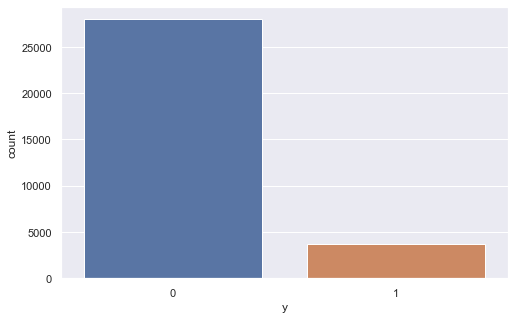

In [19]:
sns.countplot(y_train)
plt.show()

From the graph above we can see that our dataset (and training set in particular) is highly unbalanced. This in turn may lead to the issues with a model. As a result, we want to balance the training set. At the same time, we want to leave validation and train sets as they are.

In [20]:
sampler = RandomUnderSampler(random_state=SEED, replacement=True)
X_balanced, y_balanced = sampler.fit_resample(X_train, y_train)

C:\Users\artur\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


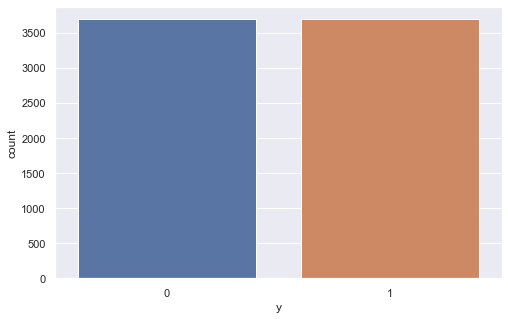

In [21]:
sns.countplot(y_balanced)
plt.show()

## Logistic Regression

### Creating a model and Testing it

Now it is time to finally build our logistic regression model.

In [22]:
classifier = LogisticRegression(max_iter=200,random_state=SEED)
classifier.fit(X_balanced, y_balanced)
y_pred = classifier.predict(X_test)
print('Accuracy score is {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score is 0.84


In [23]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[5092  897]
 [ 166  627]]


In [24]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      5989
           1       0.41      0.79      0.54       793

    accuracy                           0.84      6782
   macro avg       0.69      0.82      0.72      6782
weighted avg       0.90      0.84      0.86      6782



Wow. Thats just a lot of numbers. Lets take a deep breath, and look at the values one by one. 

accuracy score: 84% is pretty good. However, accuracy score tells us how good the model is at predicting on average. Our task, on the other hand, is to create a model that helps us to find the potential customers(i.e. people who subscribed)

confusion matrix: a few notes here. Firstly, it has a lot of false positive (897). The model predicted that 897 people subscribed whereas in reality they did not. It also has quite a few false negatives. Model predicted that 166 people did not subscribe, yet they subscribed. Overall, we can see that model has more difficulty in predicting when a person subscribed rather than not subscribed. 

classification report:

precision: how accurately the model predicts the positive outcome. We can see that 97% of the time the model predicted that the person did not subscribe it was correct. On the other hand, in only 41% of the cases when model predicted that the person subscribed it was correct.

recall: fraction of positives that were correctly identified. We can see that recall for class 0 is 0.85. This means that 85% of all 0 observations were identified as 0. In contrast, 0.79 of all 1 class observations were identified correctly.

f1 score: middle ground between recall and precision. Shows that classifying class 0 is easier for a model than class 1. 

We can clearly see the situation in which our model struggles. For class 1, it has quite high recall, yet its precision is very low. This means that the model predict class 1 way too often. 



The solution is to change the threshold at which logistic regression classifies something as class 1. The current threshold is 0.5, but the new threshold should be less than that since we are overpredicting 1 at 0.5. 

### ROC Curve

To understand what ROC curve is we have to first understand some of the definitions:

False Positive Rate: is the fraction of all negative samples classified as positive. In our case, it would be class 0 observations classified as class 1, or vice versa.

True Positive Rate: is the ratio of all positive observations, which were correctly classified.

Ideally we want the highest true positive rate and the lowest false positve rate. For this we can use the metric called G-mean (geometric mean), which is the square root of true positive rate * (1-false positive rate).

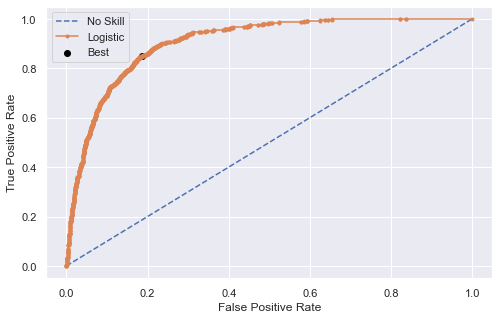

Best Threshold=0.444945, G-Mean=0.832


In [25]:
y_test_probs = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

So we can see that highest G-Mean is 0.832 and it corresponds to a 0.4449 threshold. So we can use this threshold in a logistic regression(i.e. any probability higher than 0.4449 would be 1, otherwise it would be 0).

In [26]:
y_new_pred = np.where(y_test_probs > thresholds[ix], 1, 0)
new_report = classification_report(y_test, y_new_pred)
print(new_report)
print('Accuracy score is {:.2f}'.format(accuracy_score(y_test, y_new_pred)))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      5989
           1       0.38      0.85      0.52       793

    accuracy                           0.82      6782
   macro avg       0.68      0.83      0.71      6782
weighted avg       0.91      0.82      0.85      6782

Accuracy score is 0.82


### Parameters Tuning

For parameter tuning we are going to use GridSearchCV. This is a pretty standard step

In [27]:
grid={"C":np.array([0.001,0.01,0.1,1,10]), "penalty":["l1","l2"], "solver":['liblinear', 'saga']}
cv = GridSearchCV(estimator=classifier, param_grid=grid, scoring='roc_auc', cv=10)
cv.fit(X_val, y_val)
new_classifier = LogisticRegression(solver=cv.best_params_['solver'],max_iter=200,random_state=SEED, C=cv.best_params_['C'], penalty=cv.best_params_['penalty'])
new_classifier.fit(X_train, y_train)
final_pred = np.where(new_classifier.predict_proba(X_test)[:,1] > thresholds[ix], 1, 0)
print(classification_report(y_test, final_pred))
print('Accuracy score is {:.2f}'.format(accuracy_score(y_test, final_pred)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5989
           1       0.63      0.36      0.46       793

    accuracy                           0.90      6782
   macro avg       0.77      0.67      0.70      6782
weighted avg       0.89      0.90      0.89      6782

Accuracy score is 0.90


In [28]:
cv = GridSearchCV(estimator=classifier, param_grid=grid, scoring='roc_auc', cv=10)
cv.fit(X_val, y_val)
new_classifier = LogisticRegression(solver=cv.best_params_['solver'],max_iter=200,random_state=SEED, C=cv.best_params_['C'], penalty=cv.best_params_['penalty'])
new_classifier.fit(X_train, y_train)
final_pred = np.where(new_classifier.predict_proba(X_test)[:,1] > thresholds[ix], 1, 0)
print(classification_report(y_test, final_pred))
print('Accuracy score is {:.2f}'.format(accuracy_score(y_test, final_pred)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      5989
           1       0.63      0.36      0.46       793

    accuracy                           0.90      6782
   macro avg       0.77      0.67      0.70      6782
weighted avg       0.89      0.90      0.89      6782

Accuracy score is 0.90


## Conclusion

We have created three models that performed differently. Let´s look at each of them separately and analyse which one is more suitable for the task. 

First model had low precision, high recall for class 1 observations. This means that we were able to find nearly 80% of all class 1 observations; however, the model has precision is 41%, which is not great. As discussed above, this means that we overpredict potential customers, and less than a half of these customers are actually in class 1 (i.e. subscribed), yet this 41% account for 80% of all subscribed customers. 

Second model has an improved recall, but even worse precision. 

Finally, the third model has high precision, low recall. It was able to identify only 36% of all class 1 observations, yet it has 63% precision score. 

So which model is better?

To answer this, we have to think back about our task. The bank wants to have as much new customers as possible. So ideally we want to reach as much potential customers as possible. Thus we want high recall. Yet, contacting customers is not an issue for the bank, so if model overpredicts (i.e. has low precision), but reaches a lot of potential customers (i.e. has high recall), bank would benefit from it. 

So we can conclude that for this task, the second model is the best choice. 

Now some might ask, isn´t high recall, low precision is always better. Not necessarily! For instance, if we have a spam detection algorithm, we are fine with some spam emails not getting recognised as spam, yet we don´t want important emails to be recognised as spam. In this case, high precision is more important than recall. 